# DMRG runs

In this notebook, we use the `SimpleDMRGEngine` class from `toycodes/d_dmrg.py` to run DMRG and find MPS ground states.

In [7]:
# standard imports and cosmetics

import numpy as np

import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True, linewidth=100, threshold=50)
plt.rcParams['figure.dpi'] = 150

In previous notebooks, we learned how to initialize `SimpleMPS`...

In [8]:
from toycodes.a_mps import SimpleMPS, init_FM_MPS, init_Neel_MPS

In [9]:
L = 12

In [10]:
psi_FM = init_FM_MPS(L=L, d=2, bc='finite')
print(psi_FM)
SigmaZ = np.diag([1., -1.])
print(psi_FM.site_expectation_value(SigmaZ))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
def init_PM_MPS(L, bc='finite'):
    """Return a paramagnetic MPS (= product state with all spins pointing in +x direction)"""
    d = 2
    B = np.zeros([1, d, 1], dtype=float)
    B[0, 0, 0] = 1./np.sqrt(2)
    B[0, 1, 0] = 1./np.sqrt(2)
    S = np.ones([1], dtype=float)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return SimpleMPS(Bs, Ss, bc=bc)

... and how to initialize the `TFIModel`.

In [12]:
from toycodes.b_model import TFIModel

g = 1.2
model = TFIModel(L=L, J=1., g=g, bc='finite')

print("<H_bonds> = ", psi_FM.bond_expectation_value(model.H_bonds))
print("energy:", np.sum(psi_FM.bond_expectation_value(model.H_bonds)))
# (make sure the model and state have the same length and boundary conditions!)

<H_bonds> =  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
energy: -11.0



For small enough system size $L \lesssim 16$, you can compare the energies to exact diagonalization in the full Hilbert space (which is exponentially expensive!):

In [13]:
from toycodes.tfi_exact import finite_gs_energy

if L <= 16:
    energy_exact = finite_gs_energy(L=L, J=1., g=g)

## The DMRG algorithm

The file `toycodes/d_dmrg.py` implements the DMRG algorithm.
It can be called like this:

In [14]:
from toycodes.d_dmrg import SimpleDMRGEngine, SimpleHeff2

In [9]:
chi_max = 15

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-10)
for i in range(10):
    E_dmrg = eng.sweep()
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
if model.L <= 16:
    E_exact = finite_gs_energy(L=model.L, J=model.J, g=model.g)
    print("err in energy = {err:.3e}".format(err=E - E_exact))

sweep  1: E = -16.7887686421687
sweep  2: E = -16.7865402682303
sweep  3: E = -16.7865402285887
sweep  4: E = -16.7865402285887
sweep  5: E = -16.7865402285887
sweep  6: E = -16.7865402285887
sweep  7: E = -16.7865402285887
sweep  8: E = -16.7865402285887
sweep  9: E = -16.7865402285887
sweep 10: E = -16.7865402285887
final bond dimensions:  [2, 4, 8, 14, 15, 15, 15, 14, 8, 4, 2]
magnetization in X = 0.81887
magnetization in Z = 0.00000
err in energy = 0.000e+00


### Exercise: read d_dmrg.py

Read the code of `toycodes/d_dmrg.py` and try to undertstand the general structure of how it works.


## Exercise: measure correlation functions

Just looking at expectation values of local operators is not enough.
Also measure correlation functions $\langle Z_{L/4} Z_{3L/4} \rangle $.

In [10]:
corr = psi.correlation_function(model.sigmaz, model.L//4, model.sigmaz, model.L * 3 // 4)
print("correlation <Sz_L/4 Sz_3L/4> = {corr:.5f}".format(corr=corr))


correlation <Sz_L/4 Sz_3L/4> = 0.08762


## Exercise: DMRG runs

Try running DMRG for various different parameters:

- Change the bond dimension `chi` and truncation threashold `eps`.
- Change the system size `L`
- Change the model parameter `g` (at fixed $J=1$) to both the ferromagnetic phase $g<J$ 
  and the paramagnetic phase $g>1$.
- Change the initial state.



In [11]:
chi_max, eps = 15, 1.e-10
g = 1.2
L = 12

model = TFIModel(L=L, J=1., g=g, bc='finite')
psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=eps)
for i in range(10):
    E_dmrg = eng.sweep()
    E = np.sum(psi.bond_expectation_value(model.H_bonds))
    print("sweep {i:2d}: E = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
if model.L <= 16:
    E_exact = finite_gs_energy(L=model.L, J=model.J, g=model.g)
    print("err in energy = {err:.3e}".format(err=E - E_exact))
corr = psi.correlation_function(model.sigmaz, model.L//4, model.sigmaz, model.L * 3 // 4)
print("correlation <Sz_L/4 Sz_3L/4> = {corr:.5f}".format(corr=corr))

sweep  1: E = -16.7887686421687
sweep  2: E = -16.7865402682303
sweep  3: E = -16.7865402285887
sweep  4: E = -16.7865402285887
sweep  5: E = -16.7865402285887
sweep  6: E = -16.7865402285887
sweep  7: E = -16.7865402285887
sweep  8: E = -16.7865402285887
sweep  9: E = -16.7865402285887
sweep 10: E = -16.7865402285887
final bond dimensions:  [2, 4, 8, 14, 15, 15, 15, 14, 8, 4, 2]
magnetization in X = 0.81887
magnetization in Z = 0.00000
err in energy = -6.040e-14
correlation <Sz_L/4 Sz_3L/4> = 0.08762


## Exercise: Phase diagram

To map out the phase diagram, it can be convenient to define a function that just runs DMRG for a given model. Fill in the below template. Use it obtain and plot the energy, correlations and magnetizations for different $L$ against $g$.

In [36]:
def run_DMRG(model, chi_max=50):
    print(f"runnning DMRG for L={model.L:d}, g={model.g:.2f}, bc={model.bc}, chi_max={chi_max:d}")
    psi = init_FM_MPS(model.L, model.d, model.bc)
    eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=eps)
    for i in range(10):
        E_dmrg = eng.sweep() 
    return psi

In [44]:
results_all = {}
# TIP: comment this out after the first run to avoid overriding your data!

In [53]:
L = 64  # rerun for different L!

mag_X = []
mag_Z = []
E = []
corr = []
max_chi = []

gs = [0.1, 0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5]
for g in gs:
    model = TFIModel(L=L, J=1., g=g, bc='finite')
    psi = run_DMRG(model)
    mag_X.append(np.mean(psi.site_expectation_value(model.sigmax)))
    mag_Z.append(np.mean(psi.site_expectation_value(model.sigmaz)))
    E.append(np.sum(psi.bond_expectation_value(model.H_bonds)))
    corr.append(psi.correlation_function(model.sigmaz, model.L//4, model.sigmaz, model.L * 3 // 4))
    max_chi.append(max(psi.get_chi()))

results_all[L] = {
    'g': gs,
    'mag_X': mag_X,
    'mag_Z': mag_Z,
    'E': E,
    'corr': corr,
    'max_chi': max_chi
}

runnning DMRG for L=64, g=0.10, bc=finite, chi_max=50
runnning DMRG for L=64, g=0.50, bc=finite, chi_max=50
runnning DMRG for L=64, g=0.80, bc=finite, chi_max=50
runnning DMRG for L=64, g=0.90, bc=finite, chi_max=50
runnning DMRG for L=64, g=1.00, bc=finite, chi_max=50
runnning DMRG for L=64, g=1.10, bc=finite, chi_max=50
runnning DMRG for L=64, g=1.20, bc=finite, chi_max=50
runnning DMRG for L=64, g=1.50, bc=finite, chi_max=50


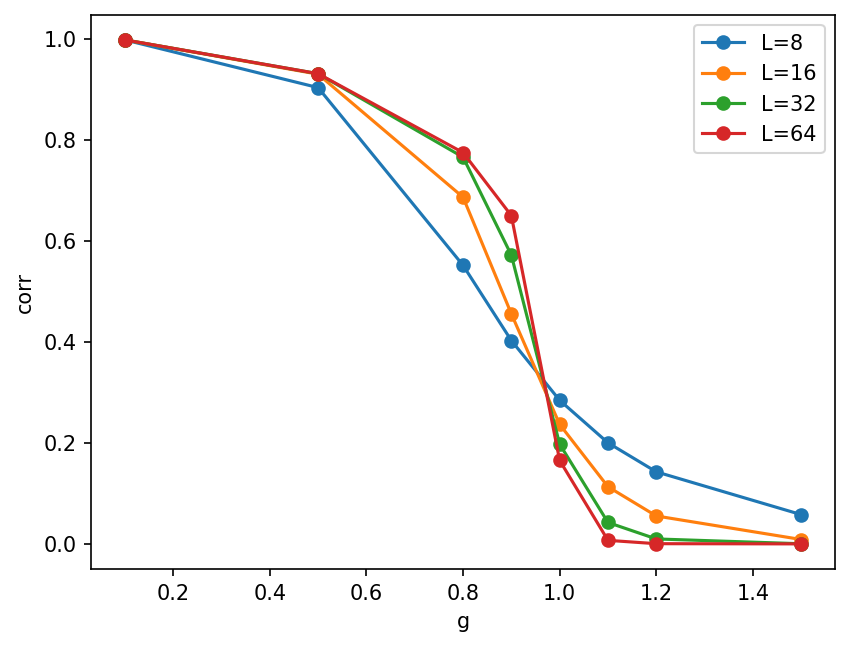

In [54]:
key = 'corr'

plt.figure()
for L in results_all:
    res_L = results_all[L]
    plt.plot(res_L['g'], res_L[key], marker='o', label="L={L:d}".format(L=L))
plt.xlabel('g')
plt.ylabel(key)
plt.legend(loc='best')

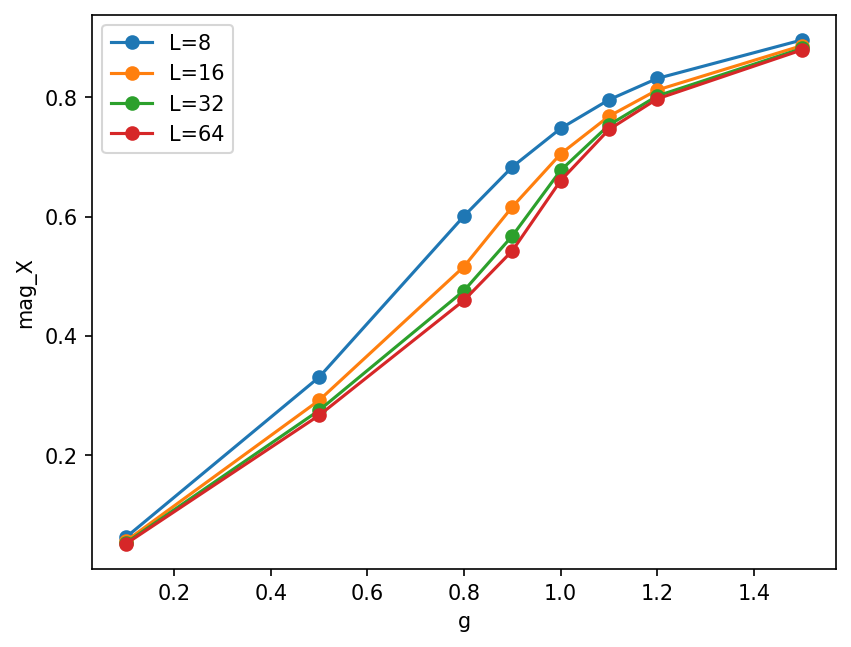

In [55]:
key = 'mag_X'

plt.figure()
for L in results_all:
    res_L = results_all[L]
    plt.plot(res_L['g'], res_L[key], marker='o', label="L={L:d}".format(L=L))
plt.xlabel('g')
plt.ylabel(key)
plt.legend(loc='best')

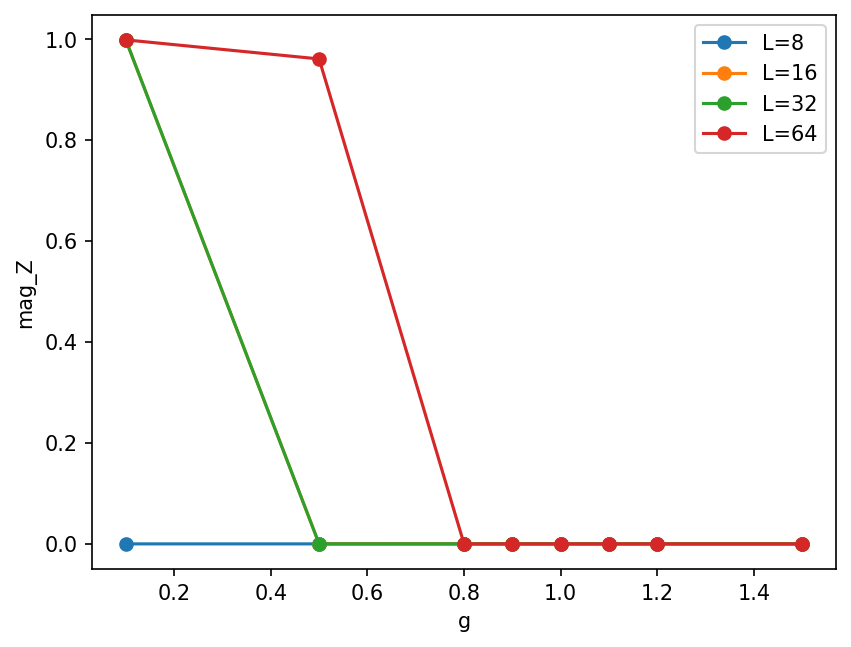

In [56]:
key = 'mag_Z'

plt.figure()
for L in results_all:
    res_L = results_all[L]
    plt.plot(res_L['g'], res_L[key], marker='o', label="L={L:d}".format(L=L))
plt.xlabel('g')
plt.ylabel(key)
plt.legend(loc='best')

You might wonder what is going on in the plot of `mag_Z` above in the ferromagnetic phase `g < J`.
In this phase, the system spontaneoulsy breaks the symmetry in the thermodynamic limit, with two ground states  $ \lvert Z \approx \pm 1\rangle$. In the finite systems, there is a small splitting into the symmetric and anti-symmetric superpositions $\lvert Z \approx 1 \rangle \pm \lvert Z \approx -1 \rangle $ ("cat states"), so that the true finite-L ground state has $\langle Z\rangle = 0$.
However, for larger $L$, this splitting can no longer be resolved, and DMRG breaks the symmetry since this lowers energy due to a smaller truncation error - a cat state needs significantly larger bond dimensions at the same precision.

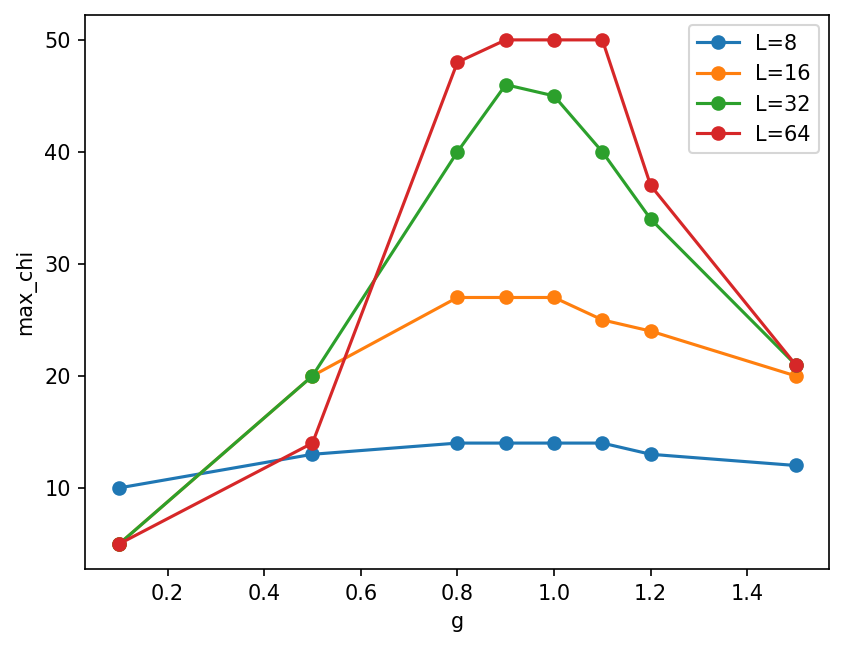

In [57]:
key = 'max_chi'

plt.figure()
for L in results_all:
    res_L = results_all[L]
    plt.plot(res_L['g'], res_L[key], marker='o', label="L={L:d}".format(L=L))
plt.xlabel('g')
plt.ylabel(key)
plt.legend(loc='best')

## Infinite DMRG

The given DMRG code also works with `bc='infinite'` boundary conditions of the model and state.
The given `SimpleDMRG` code also allows to run infinite DMRG, simply by replacing the `bc='finite'` for both the model and the MPS. 

- Look at the implementation of `d_dmrg.py` to see where the differences are.

Again, we can compare to analytic calculations possible for the Transverse Field Ising model.
  

In [15]:
from toycodes.tfi_exact import infinite_gs_energy


The `L` parameter now just indices the number of tensors insite the unit cell of the infinite MPS.
It has to be at least `2`, since we optimize 2 tensors at once in our DMRG code.
Note that we now use the `mean` to calculate densities of observables instead of extensive quantities:

In [16]:
model = TFIModel(L=2, J=1., g=0.8, bc='infinite')  # just change bc='infinite' here

chi_max = 10

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-7)
for i in range(10):
    E_dmrg = eng.sweep()
    E = np.mean(psi.bond_expectation_value(model.H_bonds))
    print("sweep {i:2d}: E/L = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization density in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization density in Z = {mag_z:.5f}".format(mag_z=mag_z))
E_exact = infinite_gs_energy(model.J, model.g)
print("err in energy = {err:.3e}".format(err=E - E_exact))

sweep  1: E/L = -1.1691320258028
sweep  2: E/L = -1.1859218684668
sweep  3: E/L = -1.1830439651388
sweep  4: E/L = -1.1768668631138
sweep  5: E/L = -1.1725334866568
sweep  6: E/L = -1.1700487255459
sweep  7: E/L = -1.1688086884548
sweep  8: E/L = -1.1682394025940
sweep  9: E/L = -1.1679905285657
sweep 10: E/L = -1.1678847922595
final bond dimensions:  [10, 10]
magnetization density in X = 0.44415
magnetization density in Z = -0.00000
err in energy = -7.528e-05


### Exercise: Infinite DMRG

Try running the infinite DMRG code. How many sweeps do you now need to perform to converge now?
  Does it depend on `g` and `chi`?

In [20]:
model = TFIModel(L=2, J=1., g=0.8, bc='infinite')  # just change bc='infinite' here

chi_max = 10

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-7)
for i in range(100):
    E_dmrg = eng.sweep()
    E = np.mean(psi.bond_expectation_value(model.H_bonds))
    if i % 10 == 9:
        print("sweep {i:2d}: E/L = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization density in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization density in Z = {mag_z:.5f}".format(mag_z=mag_z))
E_exact = infinite_gs_energy(model.J, model.g)
print("err in energy = {err:.3e}".format(err=E - E_exact))

sweep 10: E/L = -1.1678847922595
sweep 20: E/L = -1.1678095166355
sweep 30: E/L = -1.1678581030541
sweep 40: E/L = -1.1678095085625
sweep 50: E/L = -1.1678095085207
sweep 60: E/L = -1.1678095085207
sweep 70: E/L = -1.1678095085207
sweep 80: E/L = -1.1678095085207
sweep 90: E/L = -1.1678095085207
sweep 100: E/L = -1.1678095085207
final bond dimensions:  [10, 10]
magnetization density in X = 0.44407
magnetization density in Z = 0.88011
err in energy = -6.994e-14


In [21]:
model = TFIModel(L=2, J=1., g=1.0, bc='infinite')  # just change bc='infinite' here

chi_max = 10

psi = init_FM_MPS(model.L, model.d, model.bc)
eng = SimpleDMRGEngine(psi, model, chi_max=chi_max, eps=1.e-7)
for i in range(100):
    E_dmrg = eng.sweep()
    E = np.mean(psi.bond_expectation_value(model.H_bonds))
    if i % 10 == 9:
        print("sweep {i:2d}: E/L = {E:.13f}".format(i=i + 1, E=E))
print("final bond dimensions: ", psi.get_chi())
mag_x = np.mean(psi.site_expectation_value(model.sigmax))
mag_z = np.mean(psi.site_expectation_value(model.sigmaz))
print("magnetization density in X = {mag_x:.5f}".format(mag_x=mag_x))
print("magnetization density in Z = {mag_z:.5f}".format(mag_z=mag_z))
E_exact = infinite_gs_energy(model.J, model.g)
print("err in energy = {err:.3e}".format(err=E - E_exact))

sweep 10: E/L = -1.2734731285873
sweep 20: E/L = -1.2732892142506
sweep 30: E/L = -1.2732583617401
sweep 40: E/L = -1.2732481551659
sweep 50: E/L = -1.2732435768774
sweep 60: E/L = -1.2732411321859
sweep 70: E/L = -1.2732396732724
sweep 80: E/L = -1.2732387344249
sweep 90: E/L = -1.2732380971634
sweep 100: E/L = -1.2732376474834
final bond dimensions:  [10, 10]
magnetization density in X = 0.63816
magnetization density in Z = 0.00000
err in energy = 1.897e-06


From the exercise, you should see that you need significantly more sweeps when the correlation length gets larger, in particular at the critical point! At the critical point, the [correlation length (of infinite MPS) scales](https://arxiv.org/abs/0812.2903) as $\xi \propto \chi^\kappa$, so you again need more sweeps to converge at larger bond dimensions.

### Advanced exercises for the experts (and those who want to become them ;-) )

- Obtain the ground state of the transverse field ising model at the critical point with DMRG for large `L`.
  Try to plot the corrlation function as a function of `j-i`.
  What form does it have? Is an MPS a good ansatz for that?






In [3]:
# At the critical point, correlations decay like a power law.
# An MPS can only approximate powerlaws by sums of (decaying) exponentials, 
# that decay too fast at long distances.
# In practice, increasing the bond dimension allows to approximate the power laws better and better, so one can still use DMRG.

- Compare running DMRG and imaginary time evolution with TEBD from `toycodes/c_tebd.py` 
  for various parameters of `L`, `J`, `g`, and `bc`. Which one is faster? Do they always agree?

In [5]:
# imaginary time evolution is significantly slower than the variational DMRG ansatz
# They can give different results e.g. in the symmetry broken phase, 
# where TEBD might return a symmetric superposition (cat state), 
# while DMRG tends to break the symmetries.
